# Performance evaluation of unsupervised stream anomaly detection algorithms on BETH dataset

In [ ]:
!pip install numpy pandas matplotlib seaborn sklearn tqdm

In [ ]:
!pip install pynomaly river streamad pysad

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from tqdm import tqdm
import copy
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import os
from collections import namedtuple

from streamad.model import xStreamDetector, RrcfDetector, LodaDetector, HSTreeDetector, RShashDetector
from streamad.process import ZScoreCalibrator

from river import anomaly
from river import stream
from river import compose
from river import preprocessing

from pysad.models import xStream, IForestASD, ExactStorm, LODA, HalfSpaceTrees, KitNet, KNNCAD, RSHash, RobustRandomCutForest, LocalOutlierProbability, MedianAbsoluteDeviation

from sklearn.metrics import roc_auc_score

In [2]:
TRAINING_FILE = "labelled_training_data.csv"
VALIDATION_FILE = "labelled_validation_data.csv"
TESTING_FILE = "labelled_testing_data.csv"

PROJ_DIR = Path().resolve().parents[0]
DATA_DIR =   PROJ_DIR / "data/"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

REPORTS_DIR = PROJ_DIR / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"

THRESHOLD = 0.95
SEED = 2025

Downloading and unzipping

In [3]:
!curl -L -o ../data/raw/beth-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/katehighnam/beth-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 39.7M  100 39.7M    0     0  2469k      0  0:00:16  0:00:16 --:--:-- 2998k 6798k    0     0  1563k      0  0:00:26  0:00:04  0:00:22 2222k


In [4]:
with zipfile.ZipFile(RAW_DATA_DIR/"beth-dataset.zip", "r") as zf:
    zf.extract(TRAINING_FILE, RAW_DATA_DIR)
    zf.extract(TESTING_FILE, RAW_DATA_DIR)
    zf.extract(VALIDATION_FILE, RAW_DATA_DIR)

In [5]:
train_df  = pd.read_csv(RAW_DATA_DIR / TRAINING_FILE)
val_df = pd.read_csv(RAW_DATA_DIR / VALIDATION_FILE)
test_df = pd.read_csv(RAW_DATA_DIR / TESTING_FILE)

train_df_sorted = train_df.sort_values(['hostName', 'timestamp'], ignore_index=True)

### Event order in train dataframe
I have no idea which is right, so let's examine on both

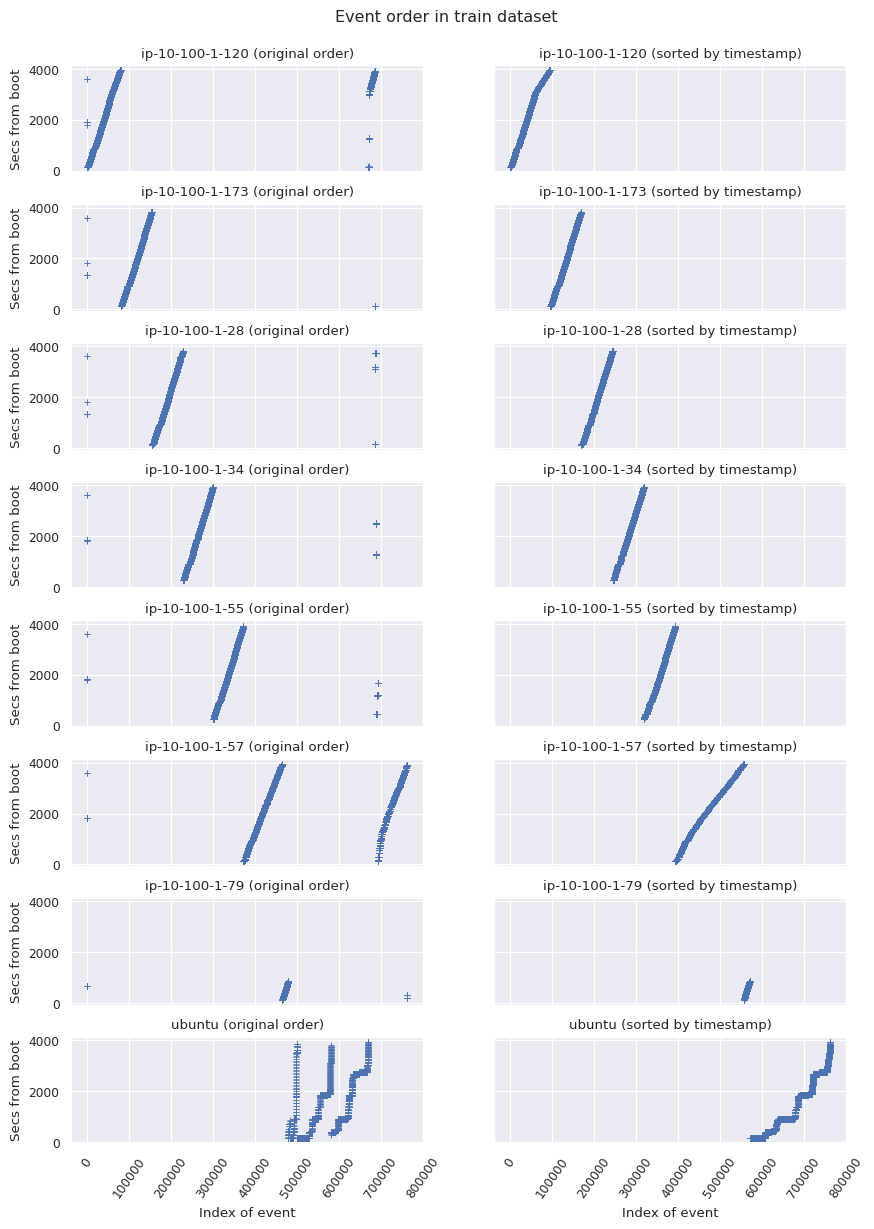

In [6]:
hostnames = train_df.hostName.unique()

sns.set_theme()
sns.set_context("paper")

fig, axes = plt.subplots(len(hostnames), 2,
                 figsize=(10, 14), sharex=True, sharey=True)


for ax_i in range(len(hostnames)):
    ax = axes[ax_i][0]
    ax.set_title(hostnames[ax_i] + " (original order)")
    ax.set_ylabel("Secs from boot")
    if ax_i == len(hostnames)-1:
        ax.set_xlabel("Index of event")
    ax.tick_params(axis="x", rotation=55)
    sns.scatterplot(train_df[train_df.hostName == hostnames[ax_i]].timestamp,
                    marker="+",
                    ax = ax)

    ax = axes[ax_i][1]
    ax.set_title(hostnames[ax_i]+ " (sorted by timestamp)")
    # ax.set_ylabel("Secs from boot")
    if ax_i == len(hostnames)-1:
        ax.set_xlabel("Index of event")
    ax.tick_params(axis="x", rotation=55)
    sns.scatterplot(train_df_sorted[train_df_sorted.hostName == hostnames[ax_i]].timestamp,
                    marker="+",
                    ax = ax)

fig.suptitle("Event order in train dataset", y=0.92)
plt.subplots_adjust(hspace=0.3)
fig.align_labels()

fig.savefig(FIGURES_DIR / "event_order.png", dpi=300)

Processing functions. In real situation it should be done in a streaming manner

In [7]:
def prepare_dataset(df_original: pd.DataFrame, only_evil=False, enrich = False):
    df = df_original.copy()    
    # Map process ID to OS process(0) vs user process(1).
    df['processId_nonOS'] = df['processId'].map(lambda x: 0 if x in [0, 1, 2] else 1)
    # Map parent process ID to OS process(0) vs user process(1).
    df['parentProcessId_nonOS'] = df['parentProcessId'].map(lambda x: 0 if x in [0, 1, 2] else 1)
    # Map user ID to OS(0) vs user(1).
    df['userId_nonOS'] = df['userId'].map(lambda x: 0 if x < 1000 else 1)
    # Map mount access to folder mnt/ (all non-OS users)(0) vs elsewhere(1).
    df['mountNamespace'] = df['mountNamespace'].map(lambda x: 0 if x == 4026531840 else 1)    
    # Map return value to success(0) vs success with returned value(1) vs success with error(2).
    df['returnValue_error'] = df['returnValue'].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))
  
    fields = ['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue',
            'processId_nonOS', 'parentProcessId_nonOS', 'userId_nonOS', 'returnValue_error']
    if enrich:
        fields.append('processName')
        fields.append('parentProcessName')
    
    X = df[fields].copy()

    y = df['sus'].copy()            
    if only_evil:
        y = df['evil'].copy()
    y[y == 1] = True 
    y[y == 0] = False  
  
    return X, y     

In [8]:
def enrich_parent_process_name(row: pd.DataFrame, process_vocab: dict, timestamp_update: float):
    if row['timestamp'] < timestamp_update:
        process_vocab = {}    
    timestamp_update = row['timestamp']
    
    process_vocab[(row['hostName'], row['processId'])] = row['processName']     
    
    if (row['hostName'], row['parentProcessId']) in process_vocab.keys():
        row['parentProcessName'] = process_vocab[(row['hostName'], row['parentProcessId'])]
    else:
        row['parentProcessName'] = None
        
    return row

Let's get feature dataframes for experiments

In [9]:
X_train, y_train_sus = prepare_dataset(train_df)
_, y_train_evil = prepare_dataset(train_df, only_evil=True)
X_val, y_val_sus = prepare_dataset(val_df)
_, y_val_evil = prepare_dataset(val_df, only_evil=True)
X_test, y_test_sus = prepare_dataset(test_df)
_, y_test_evil = prepare_dataset(test_df, only_evil=True)

X_train_sorted, y_train_sus_sorted = prepare_dataset(train_df_sorted)
_, y_train_evil_sorted = prepare_dataset(train_df_sorted, only_evil=True)


In [10]:
X_train.to_csv(PROCESSED_DATA_DIR / "X_train.csv")
X_val.to_csv(PROCESSED_DATA_DIR / "X_val.csv")
X_test.to_csv(PROCESSED_DATA_DIR / "X_test.csv")

y_train_sus.to_csv(PROCESSED_DATA_DIR / "y_train_sus.csv")
y_train_evil.to_csv(PROCESSED_DATA_DIR / "y_train_evil.csv")
y_val_sus.to_csv(PROCESSED_DATA_DIR / "y_val_sus.csv")
y_val_evil.to_csv(PROCESSED_DATA_DIR / "y_val_evil.csv")
y_test_sus.to_csv(PROCESSED_DATA_DIR / "y_test_sus.csv")
y_test_evil.to_csv(PROCESSED_DATA_DIR / "y_test_evil.csv")

X_train_sorted.to_csv(PROCESSED_DATA_DIR / "X_train_sorted.csv")
y_train_sus_sorted.to_csv(PROCESSED_DATA_DIR / "y_train_sus_sorted.csv")
y_train_evil_sorted.to_csv(PROCESSED_DATA_DIR / "y_train_evil_sorted.csv")


Enriching dataframes with parent process name.

In real situation also should be done in a streaming manner.

This cell execution takes about ten minutes

In [11]:
process_vocab = {}
timestamp_update = 0.0
train_df_enriched = train_df.apply(enrich_parent_process_name, process_vocab=process_vocab,
                                   timestamp_update=timestamp_update, axis=1)
val_df_enriched = val_df.apply(enrich_parent_process_name, process_vocab=process_vocab,
                               timestamp_update=timestamp_update, axis=1)
test_df_enriched = test_df.apply(enrich_parent_process_name, process_vocab=process_vocab,
                                 timestamp_update=timestamp_update, axis=1)

process_vocab = {}
timestamp_update = 0.0
train_df_sorted_enriched = train_df_sorted.apply(enrich_parent_process_name, process_vocab=process_vocab,
                                                 timestamp_update=timestamp_update, axis=1)

In [12]:
X_train_enriched = None
X_val_enriched = None
X_test_enriched = None
X_train_sorted_enriched = None

if os.path.exists(PROCESSED_DATA_DIR / "X_train_enriched.csv"):
    X_train_enriched = pd.read_csv(PROCESSED_DATA_DIR / "X_train_enriched.csv", index_col=0)
else:
    X_train_enriched, _ = prepare_dataset(train_df_enriched, enrich=True)

if os.path.exists(PROCESSED_DATA_DIR / "X_val_enriched.csv"):
    X_val_enriched = pd.read_csv(PROCESSED_DATA_DIR / "X_val_enriched.csv", index_col=0)
else:
    X_val_enriched, _ = prepare_dataset(val_df_enriched, enrich=True)

if os.path.exists(PROCESSED_DATA_DIR / "X_test_enriched.csv"):
    X_test_enriched = pd.read_csv(PROCESSED_DATA_DIR / "X_test_enriched.csv", index_col=0)
else:
    X_test_enriched, _ = prepare_dataset(test_df_enriched, enrich=True)

if os.path.exists(PROCESSED_DATA_DIR / "X_train_sorted_enriched.csv"):
    X_train_sorted_enriched = pd.read_csv(PROCESSED_DATA_DIR / "X_train_sorted_enriched.csv", index_col=0)
else:
    X_train_sorted_enriched, _= prepare_dataset(train_df_sorted_enriched, enrich=True)


In [13]:
X_train_enriched.to_csv(PROCESSED_DATA_DIR / "X_train_enriched.csv")    
X_val_enriched.to_csv(PROCESSED_DATA_DIR / "X_val_enriched.csv")
X_test_enriched.to_csv(PROCESSED_DATA_DIR / "X_test_enriched.csv")

X_train_sorted_enriched.to_csv(PROCESSED_DATA_DIR / "X_train_sorted_enriched.csv")

Function for predicting anomalies with particular model.

Only train and test data used (no validation).

Fitting and scoring on both train and test.

In [14]:
def fit_score_model(model,
               X_train, X_test,
               scaler = None,
               encoder = None,
               probability_threshold = THRESHOLD):
    calibrator = ZScoreCalibrator(sigma=3, extreme_sigma=5, is_global=True)
    
    preds = []
    scores = []
    normalized_scores = []
    duration = []
    
    module = model.__module__    

    start = time.time()
    
    for x, _  in tqdm(stream.iter_pandas(X_train)):     
        score = None

        if encoder != None and 'processName' in x and 'parentProcessName' in x:
            encoder.learn_one(x)            
            x = encoder.transform_one(x)

        if scaler != None:
            scaler.learn_one(x)
            x = scaler.transform_one(x)

        if module.startswith("river"):        
            model.learn_one(x)        
            score = model.score_one(x) 
        elif module.startswith("pysad"):        
            X = np.array(list(x.values()))            
            model.fit_partial(X)  
            score = model.score_partial(X)            
        elif module.startswith("streamad"):        
            score = model.fit_score(np.array(list(x.values())))

        if type(score) == np.ndarray:
            score = score[0]                
        calibrator.normalize(score)
        
    for x, _ in tqdm(stream.iter_pandas(X_test)):
        score = None
        is_anomaly = False

        if encoder != None and 'processName' in x and 'parentProcessName' in x:
            encoder.learn_one(x)            
            x = encoder.transform_one(x)

        if scaler != None:
            scaler.learn_one(x)
            x = scaler.transform_one(x)

        if module.startswith("river"):        
            score = model.score_one(x)               
            is_anomaly = model['filter'].classify(score)
            model.learn_one(x)
        elif module.startswith("pysad"):        
            X = np.array(list(x.values()))                        
            score = model.fit_score_partial(X)            
        elif module.startswith("streamad"):        
            score = model.fit_score(np.array(list(x.values())))            

        if type(score) == np.ndarray:
            score = score[0]
                                
        normalized_score = calibrator.normalize(score)
        if normalized_score!= None and normalized_score > probability_threshold and \
            not module.startswith("river"):
            is_anomaly = True
        
        duration = time.time() - start

        scores.append(score)
        normalized_scores.append(normalized_score)
        preds.append(is_anomaly)
                
    return {'preds': preds,
            'scores': scores,
            'normalized_scores': normalized_scores,
            'time': duration}

In [15]:
def get_roc_auc(y_true: list, scores: list, invert = False) -> float:
    result = roc_auc_score(np.array(y_true, dtype=bool), np.array(scores))
    is_inverted = False    
    if result < 0.5:
        result_inverted = roc_auc_score(np.array(y_true, dtype=bool), -np.array(scores)) 
        print("Reverted: ", result_inverted, result+result_inverted)
        if invert:
            is_inverted = True
            result = result_inverted                
    return result, is_inverted

In [16]:
def write_results(eval_results: namedtuple):    
    f = open(f"eval_results.txt", "a")    
    res = eval_results[-1]
    f.write(json.dumps(res._asdict()) + "\n")                    
    f.close()

Class for initializing new model instances, without knowledge of previous fittings

In [17]:
class ModelStock:

    def __init__(self):        

        self.model_params = {
            "OCSVM" : {},
            "HSTree" : {},
            "ILOF" : {},
            "RShash" : {}, 
            "xStream" : {}, 
            "IForestASD" : {},
            "RRCF" : {},            
            "KitNet" : {},
            "Storm" : {},
            "LODA" : {}
        }

        self.models =  { 
                "OCSVM": compose.Pipeline(
                    ('scale', preprocessing.StandardScaler()),
                    ('filter', anomaly.ThresholdFilter(
                        anomaly.OneClassSVM(),
                        threshold = THRESHOLD
                    ))),
                "HSTree": compose.Pipeline(
                    ('scale', preprocessing.MinMaxScaler()),                    
                    ('filter', anomaly.ThresholdFilter(
                        anomaly.HalfSpaceTrees(),
                        threshold = THRESHOLD
                    ))),
                "ILOF": compose.Pipeline(                    
                        ('filter', anomaly.ThresholdFilter(
                            anomaly.LocalOutlierFactor(),
                            threshold = THRESHOLD
                    ))),
                
                "RShash": RShashDetector(**self.model_params["RShash"]),
                "xStream": xStreamDetector(**self.model_params["xStream"]),             
                "RRCF": RrcfDetector(**self.model_params["RRCF"]),
                "LODA": LodaDetector(**self.model_params["LODA"]),

                # "RRCF": RobustRandomCutForest(**models_params["RRCF"]),
                # "xStream": xStream(**models_params["xStream"]), 
                # "LODA": LODA(**models_params["LODA"])

                "IForestASD": IForestASD(**self.model_params["IForestASD"]),                 
                "KitNet": KitNet(**self.model_params["KitNet"]),
                "Storm": ExactStorm(**self.model_params["Storm"]),                
        }

    def model(self, model_name: str):
        try:    
            return copy.deepcopy(self.models[model_name])
        except:
            if str(self.models[model_name].__class__).find("RrcfDetector") != -1:
                return RrcfDetector(**self.model_params["RRCF"])
            else:
                return None

In [18]:
modelnames = ["OCSVM", "HSTree", "ILOF",
              "RShash", "xStream", "RRCF", "LODA",
              "IForestASD", "KitNet", "Storm"]

### Evaluation
Warning : it runs about 50 hours at i7-7700. Comment modelnames or seeds for decreasing time

In [ ]:
Eval_result = namedtuple("Evaluation_result", "Algorithm Seed Sus_or_evil Sorted_train Enriched_parent_process_name Time ROCAUC_score")
eval_results = []

for s in range(SEED, SEED+5): 
    print("----------")        
    print("SEED = ", s)  
    print("----------")        
    for name in modelnames:
        
        model = ModelStock().model(name)
        np.random.seed(s)
        print("----------")        
        print("Model: ", name)
        results = fit_score_model(model, X_train, X_test)
        print("Time: ", results["time"])
        print("ROC AUC: ", get_roc_auc(y_test_sus, results["scores"]))
        print("----------")
        eval_results.append(Eval_result(name, s, "sus", "no", "no", results["time"], get_roc_auc(y_test_sus, results["scores"])))
        write_results(eval_results)

        print("ROC AUC: ", get_roc_auc(y_test_evil, results["scores"]))
        print("----------")
        eval_results.append(Eval_result(name, s, "evil", "no", "no", results["time"], get_roc_auc(y_test_evil, results["scores"])))
        write_results(eval_results)

        ###############################################
        
        model = ModelStock().model(name)
        np.random.seed(s)
        print("----------")        
        print("Model: ", name)
        results = fit_score_model(model, X_train_sorted, X_test)
        print("Time: ", results["time"])
        print("ROC AUC: ", get_roc_auc(y_test_sus, results["scores"]))
        print("----------")
        eval_results.append(Eval_result(name, s, "sus", "yes", "no", results["time"], get_roc_auc(y_test_sus, results["scores"])))
        write_results(eval_results)

        print("ROC AUC: ", get_roc_auc(y_test_evil, results["scores"]))
        print("----------")
        eval_results.append(Eval_result(name, s, "evil", "yes", "no", results["time"], get_roc_auc(y_test_evil, results["scores"])))
        write_results(eval_results)
        
        ###############################################
        
        model = ModelStock().model(name)
        np.random.seed(s)
        print("----------")        
        print("Model: ", name)
        results = fit_score_model(model, X_train_enriched, X_test_enriched, 
                              encoder=preprocessing.OrdinalEncoder())
        print("Time: ", results["time"])
        print("ROC AUC: ", get_roc_auc(y_test_sus, results["scores"]))
        print("----------")
        eval_results.append(Eval_result(name, s, "sus", "no", "yes", results["time"], get_roc_auc(y_test_sus, results["scores"])))
        write_results(eval_results)
    
        print("ROC AUC: ", get_roc_auc(y_test_evil, results["scores"]))
        print("----------")
        eval_results.append(Eval_result(name, s, "evil", "no", "yes", results["time"], get_roc_auc(y_test_evil, results["scores"])))
        write_results(eval_results)
        
        ###############################################
        
        model = ModelStock().model(name)
        np.random.seed(s)
        print("----------")        
        print("Model: ", name)
        results = fit_score_model(model, X_train_sorted_enriched, X_test_enriched, 
                              encoder=preprocessing.OrdinalEncoder())
        print("Time: ", results["time"])
        print("ROC AUC: ", get_roc_auc(y_test_sus, results["scores"]))
        print("----------")
        eval_results.append(Eval_result(name, s, "sus", "yes", "yes", results["time"], get_roc_auc(y_test_sus, results["scores"])))
        write_results(eval_results)
    
        print("ROC AUC: ", get_roc_auc(y_test_evil, results["scores"]))
        print("----------")
        eval_results.append(Eval_result(name, s, "evil", "yes", "yes", results["time"], get_roc_auc(y_test_evil, results["scores"])))
        write_results(eval_results)

In [ ]:
eval_results

In [ ]:
df_eval_results = pd.DataFrame(eval_results)

In [ ]:
df_eval_results["ROCAUC_is_inverted"] = df_eval_results["ROCAUC_score"].apply(lambda x: x[1])
df_eval_results["ROCAUC_score"] = df_eval_results["ROCAUC_score"].apply(lambda x: x[0])

In [ ]:
df_eval_results.to_csv(REPORTS_DIR / "eval_results_full.csv")

## Results

In [19]:
df_eval_results = pd.read_csv(REPORTS_DIR / "eval_results_full.csv", index_col=0)
df_eval_results

,Algorithm,Seed,Sus_or_evil,Sorted_train,Enriched_parent_process_name,Time,ROCAUC_score,ROCAUC_is_inverted
0,OCSVM,2025,sus,no,no,54.902707,0.743058,False
1,OCSVM,2025,evil,no,no,54.902707,0.658504,False
2,OCSVM,2025,sus,yes,no,56.241050,0.765240,False
3,OCSVM,2025,evil,yes,no,56.241050,0.711114,False
4,OCSVM,2025,sus,no,yes,54.140141,0.765973,False
...,...,...,...,...,...,...,...,...
395,Storm,2029,evil,yes,no,3237.162614,0.931848,False
396,Storm,2029,sus,no,yes,3219.140115,0.913466,False
397,Storm,2029,evil,no,yes,3219.140115,0.931173,False
398,Storm,2029,sus,yes,yes,3221.225365,0.913466,False


In [20]:
df_eval_results[["Algorithm", "Time", "ROCAUC_score",
                 "Sus_or_evil", "Sorted_train", "Enriched_parent_process_name"]]\
    .groupby(["Algorithm", "Sus_or_evil", "Sorted_train", "Enriched_parent_process_name"])\
    .agg(["mean", "std"])\
    .head(16)

Time  \
                                                                         mean   
Algorithm  Sus_or_evil Sorted_train Enriched_parent_process_name                
HSTree     evil        no           no                             215.254392   
                                    yes                            212.872056   
                       yes          no                             209.177235   
                                    yes                            216.205733   
           sus         no           no                             215.254392   
                                    yes                            212.872056   
                       yes          no                             209.177235   
                                    yes                            216.205733   
IForestASD evil        no           no                            1865.587141   
                                    yes                           1872.441943   
                       yes          no                            1860.351595   
                                    yes                           1870.231189   
           sus         no           no                            1865.587141   
                                    yes                           1872.441943   
                       yes          no                            1860.351595   
                                    yes                           1870.231189   

                                                                             \
                                                                        std   
Algorithm  Sus_or_evil Sorted_train Enriched_parent_process_name              
HSTree     evil        no           no                             9.093861   
                                    yes                           15.805200   
                       yes          no                             7.671838   
                                    yes                            6.950287   
           sus         no           no                             9.093861   
                                    yes                           15.805200   
                       yes          no                             7.671838   
                                    yes                            6.950287   
IForestASD evil        no           no                            11.516507   
                                    yes                           12.068878   
                       yes          no                            10.495408   
                                    yes                           12.328112   
           sus         no           no                            11.516507   
                                    yes                           12.068878   
                       yes          no                            10.495408   
                                    yes                           12.328112   

                                                                 ROCAUC_score  \
                                                                         mean   
Algorithm  Sus_or_evil Sorted_train Enriched_parent_process_name                
HSTree     evil        no           no                               0.216432   
                                    yes                              0.051764   
                       yes          no                               0.214842   
                                    yes                              0.042099   
           sus         no           no                               0.234854   
                                    yes                              0.080712   
                       yes          no                               0.222159   
                                    yes                              0.082934   
IForestASD evil        no           no                               0.709921   
                                    yes                    

Unstable results of HSTree algorithm

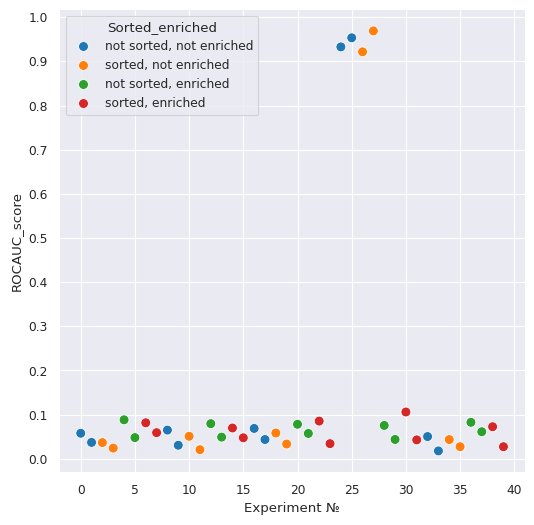

In [21]:
hstree_results = df_eval_results[df_eval_results["Algorithm"] == "HSTree"]

hstree_results["Sorted_enriched"] = hstree_results.apply(lambda x:  x["Sorted_train"] + "," + x["Enriched_parent_process_name"] , axis=1)

dict = {"no,no": "not sorted, not enriched",
        "no,yes": "not sorted, enriched",
        "yes,no": "sorted, not enriched",
        "yes,yes": "sorted, enriched"}
hstree_results.replace({"Sorted_enriched" : dict}, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

sns.set_theme()
sns.set_context("paper")
sns.despine(bottom=True, left=True)

g = sns.scatterplot(x = range(hstree_results.shape[0]), y = "ROCAUC_score",
            hue = "Sorted_enriched",
            data = hstree_results,    
            s=50,       
            palette=sns.color_palette("tab10"))


g.set(xlabel="Experiment №", ylabel="ROCAUC_score", yticks=np.arange(0.0,1.1,0.1))

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

fig.savefig(FIGURES_DIR / "rocaucs_hstree.png", dpi=300)

In [22]:
df_results = df_eval_results[["Algorithm", "Time", "ROCAUC_score",
                 "Sus_or_evil", "Sorted_train", "Enriched_parent_process_name"]]\
    .groupby(["Algorithm", "Sus_or_evil", "Sorted_train", "Enriched_parent_process_name"])\
    .agg(
        mean_time=pd.NamedAgg(column="Time", aggfunc="mean"),
        std_time=pd.NamedAgg(column="Time", aggfunc="std"),
        mean_rocauc=pd.NamedAgg(column="ROCAUC_score", aggfunc="mean"),
        std_rocauc=pd.NamedAgg(column="ROCAUC_score", aggfunc="std"),
        max_rocauc=pd.NamedAgg(column="ROCAUC_score", aggfunc="max"),
        min_rocauc=pd.NamedAgg(column="ROCAUC_score", aggfunc="min"),
        )\
    .reset_index()

In [23]:
df_results["Time"] = df_results.apply(lambda x: f"{x['mean_time']:.3f}" + '±'+ f"{x['std_time']:.3f}", axis=1)
df_results["ROCAUC"] = df_results.apply(lambda x: f"{x['mean_rocauc']:.3f}" + '±'+ f"{x['std_rocauc']:.3f}", axis=1)
df_results["Sorted_enriched"] = df_results.apply(lambda x:  x["Sorted_train"] + "," + x["Enriched_parent_process_name"] , axis=1)

dict = {"no,no": "not sorted, not enriched",
        "no,yes": "not sorted, enriched",
        "yes,no": "sorted, not enriched",
        "yes,yes": "sorted, enriched"}
df_results.replace({"Sorted_enriched" : dict}, inplace=True)

In [24]:
df_results[["Algorithm", "Sus_or_evil", "Sorted_train", "Enriched_parent_process_name", "Time", "ROCAUC"]].to_csv(REPORTS_DIR / "df_results_print.csv")

In [25]:
df_results

,Algorithm,Sus_or_evil,Sorted_train,Enriched_parent_process_name,mean_time,std_time,mean_rocauc,std_rocauc,max_rocauc,min_rocauc,Time,ROCAUC,Sorted_enriched
0,HSTree,evil,no,no,215.254392,9.093861,0.216432,0.412122,0.953460,0.017689,215.254±9.094,0.216±0.412,"not sorted, not enriched"
1,HSTree,evil,no,yes,212.872056,15.805200,0.051764,0.007195,0.061128,0.043627,212.872±15.805,0.052±0.007,"not sorted, enriched"
2,HSTree,evil,yes,no,209.177235,7.671838,0.214842,0.421636,0.969040,0.020498,209.177±7.672,0.215±0.422,"sorted, not enriched"
3,HSTree,evil,yes,yes,216.205733,6.950287,0.042099,0.012249,0.059018,0.027207,216.206±6.950,0.042±0.012,"sorted, enriched"
4,HSTree,sus,no,no,215.254392,9.093861,0.234854,0.390248,0.932836,0.050202,215.254±9.094,0.235±0.390,"not sorted, not enriched"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,xStream,evil,yes,yes,702.592074,2.585222,0.917295,0.003472,0.921874,0.912378,702.592±2.585,0.917±0.003,"sorted, enriched"
76,xStream,sus,no,no,680.400862,3.901906,0.882046,0.011170,0.890585,0.863441,680.401±3.902,0.882±0.011,"not sorted, not enriched"
77,xStream,sus,no,yes,701.266787,2.617788,0.880527,0.006607,0.888496,0.870276,701.267±2.618,0.881±0.007,"not sorted, enriched"
78,xStream,sus,yes,no,681.296280,3.362919,0.880236,0.011734,0.888556,0.859857,681.296±3.363,0.880±0.012,"sorted, not enriched"


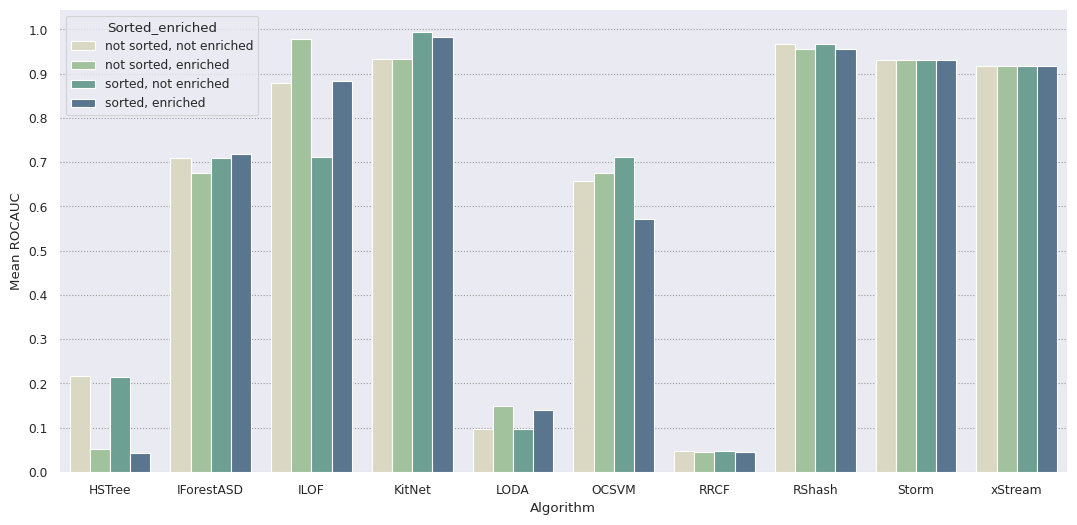

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 6)

sns.set_theme()
sns.set_context("paper")
sns.despine(bottom=True, left=True)


g = sns.barplot(x = "Algorithm" , y = "mean_rocauc",
            hue = "Sorted_enriched",
            data = df_results[df_results["Sus_or_evil"] == "evil"],
            palette=sns.cubehelix_palette(start=1, rot=-1))
# g.map(sns.barplot, color=".3")
g.set(xlabel="Algorithm", ylabel="Mean ROCAUC", yticks=np.arange(0.0,1.1,0.1))

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

fig.savefig(FIGURES_DIR / "rocaucs.png", dpi=300)

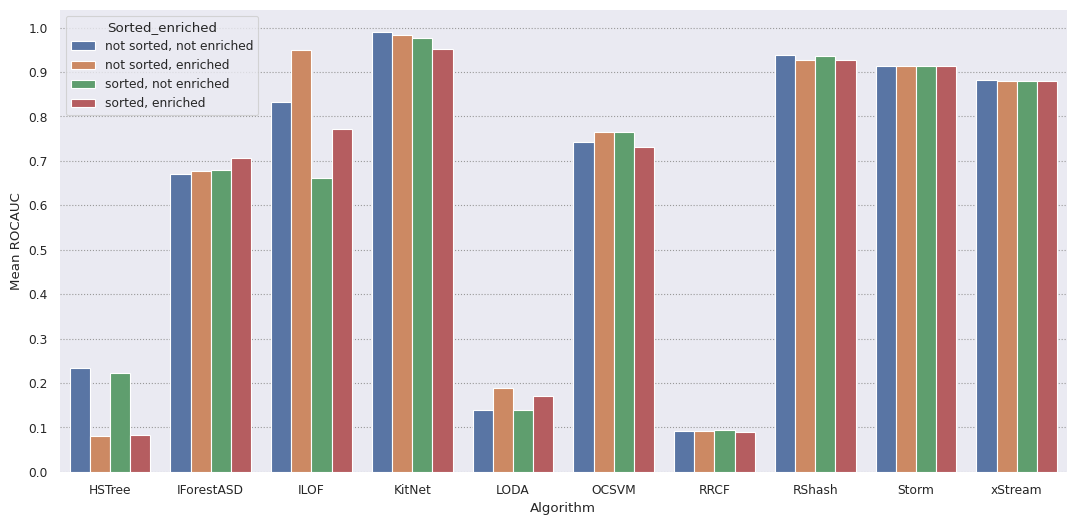

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 6)

sns.set_theme()
sns.set_context("paper")
sns.despine(bottom=True, left=True)


g = sns.barplot(x = "Algorithm" , y = "mean_rocauc",
            hue = "Sorted_enriched",
            data = df_results[df_results["Sus_or_evil"] == "sus"],
            # palette=sns.cubehelix_palette(start=1, rot=-1)
            )
# g.map(sns.barplot, color=".3")
g.set(xlabel="Algorithm", ylabel="Mean ROCAUC", yticks=np.arange(0.0,1.1,0.1))

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

fig.savefig(FIGURES_DIR / "rocaucs_sus.png", dpi=300)

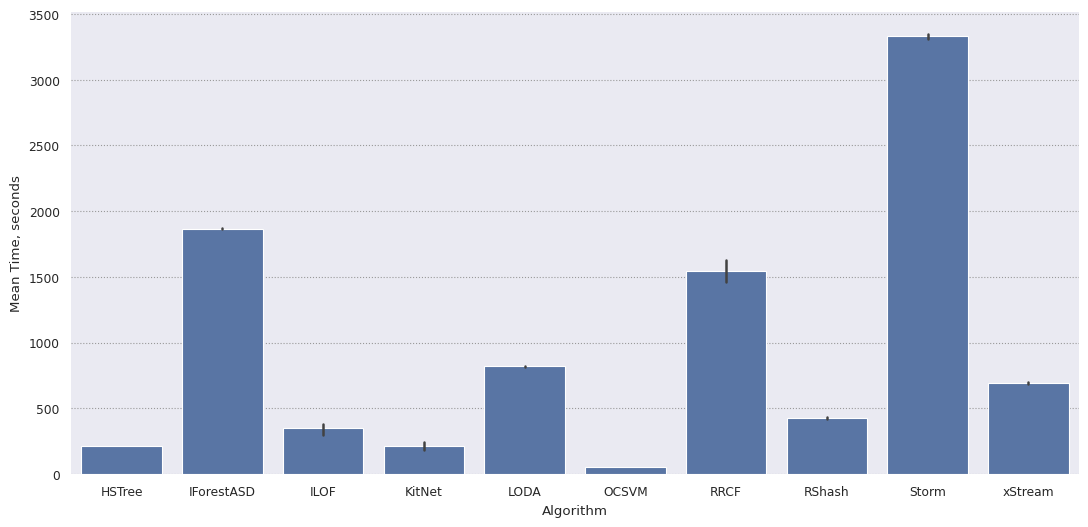

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 6)

sns.set_theme()
sns.set_context("paper")
sns.despine(bottom=True, left=True)

g = sns.barplot(x = "Algorithm" , y = "mean_time",            
            data = df_results,
            )
# g.map(sns.barplot, color=".3")
g.set(xlabel="Algorithm", ylabel="Mean Time, seconds")

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

fig.savefig(FIGURES_DIR / "times.png", dpi=300)